# CYCLOPS on Artificial Data

This notebook investigates the reordering performance of the first CYCLOPS autoencoder model on an artificially-generated dataset, which is composed of oscillatory and non-oscillatory genes. 

The python script file used to generate the data can be accessed [here](./gen.py).

## 1. Importing packages

In [1]:
from gen import *
from cyclops_v1 import *

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Generating the artificial dataset

Set parameters: number of genes & samples, period (for oscillatory genes), maximum amplitude & mean of gene expression

In [2]:
ng = 1000         # Number of genes
nc = 48           # Number of time samples

period = 24
max_amp = 20
max_mean = 20

Choose __10%__ of the genes to be __oscillatory__:

In [3]:
frac_osc = 0.1
freq = [0 if i < (1-frac_osc)*ng else 2*np.pi/period for i in range(ng)]

Set the __non-uniform__ sampling times:

In [4]:
times = [random.uniform(0,period) for i in range(nc)]
times = [round(times[i], 2) for i in range(len(times))]
times.sort()

Create a dataframe of (noisy) gene expression values with the cells (samples) as the columns, and the genes as the rows:

In [5]:
genes = [Gene(freq[i], random.random()*2*np.pi, amplitude=random.random()*max_amp, mean=random.random()*max_mean, noise_sd=0.15, name="Gene {}".format(i+1)) for i in range(ng)]
cells = [Cell(times[i], name="Cell {}".format(i+1), genes=genes) for i in range(nc)]

cell_names = [cell.name for cell in cells]
expressions = [cell.express_genes(noisy=True) for cell in cells]
df = pd.DataFrame(expressions, index=cell_names)
df.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 991,Gene 992,Gene 993,Gene 994,Gene 995,Gene 996,Gene 997,Gene 998,Gene 999,Gene 1000
Cell 1,-0.011006,0.014783,0.378927,-0.181585,-0.164489,0.130433,-0.242402,0.321200,-0.152322,-0.216696,...,12.909353,-1.695186,-0.214353,12.542059,-1.324229,0.512888,22.694816,10.648136,11.784647,15.011113
Cell 2,0.148973,-0.129964,0.149912,0.040882,0.183437,0.192138,-0.088483,0.162531,0.026755,0.038006,...,11.997002,-2.826213,-0.080218,12.992249,-0.561460,0.013991,22.467684,10.111580,10.858064,15.113407
Cell 3,0.211878,0.080638,0.053707,-0.261683,-0.028188,-0.201160,-0.081097,-0.341085,-0.029130,-0.155724,...,11.922844,-3.719472,0.422358,13.683301,0.389972,-0.649079,22.195805,8.850990,10.436100,14.594074
Cell 4,0.096027,0.059793,-0.039259,0.104099,0.026856,-0.002707,-0.064697,-0.144333,-0.233230,-0.080338,...,11.524821,-4.511411,0.727162,14.274751,0.963877,-0.804176,21.931538,8.390358,10.059236,14.873979
Cell 5,-0.293213,-0.011489,-0.017544,-0.136088,-0.142433,0.014766,-0.109910,-0.125893,-0.230618,-0.215957,...,11.760203,-4.701929,0.805584,14.623307,1.710312,-1.132944,21.709220,7.852730,9.255682,15.109136


## 3. Pre-processing data

Standardise the data to zero mean:

In [6]:
df_std = df.transform(lambda x: x-x.mean())
df_std.head()

,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,Gene 10,...,Gene 991,Gene 992,Gene 993,Gene 994,Gene 995,Gene 996,Gene 997,Gene 998,Gene 999,Gene 1000
Cell 1,0.046171,0.044015,0.407309,-0.204633,-0.135189,0.122132,-0.218346,0.357869,-0.083528,-0.206258,...,-8.269203,-3.826555,-0.303772,-5.758794,-8.734105,-16.706630,13.151985,9.033274,7.148372,-4.408779
Cell 2,0.206150,-0.100732,0.178293,0.017834,0.212737,0.183837,-0.064427,0.199199,0.095549,0.048444,...,-9.181554,-4.957581,-0.169637,-5.308604,-7.971336,-17.205527,12.924853,8.496719,6.221790,-4.306485
Cell 3,0.269055,0.109870,0.082089,-0.284731,0.001112,-0.209461,-0.057041,-0.304417,0.039664,-0.145286,...,-9.255712,-5.850840,0.332939,-4.617552,-7.019904,-17.868596,12.652974,7.236128,5.799825,-4.825818
Cell 4,0.153205,0.089026,-0.010877,0.081051,0.056156,-0.011008,-0.040641,-0.107665,-0.164436,-0.069899,...,-9.653735,-6.642779,0.637742,-4.026102,-6.446000,-18.023694,12.388707,6.775497,5.422961,-4.545913
Cell 5,-0.236035,0.017744,0.010838,-0.159136,-0.113133,0.006466,-0.085854,-0.089225,-0.161824,-0.205519,...,-9.418353,-6.833297,0.716165,-3.677546,-5.699564,-18.352462,12.166389,6.237868,4.619407,-4.310756


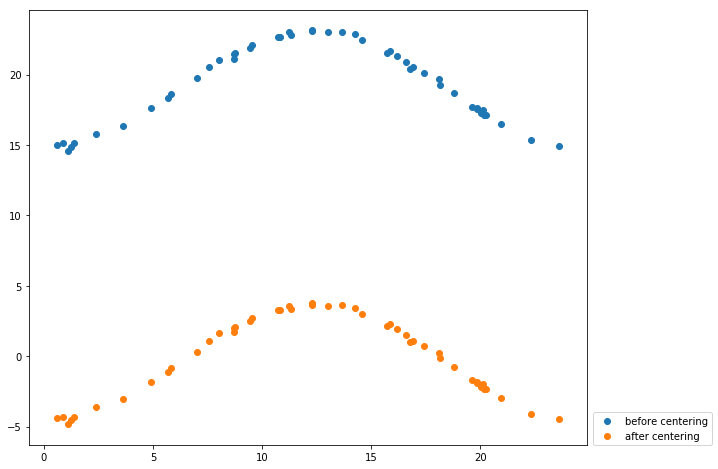

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(times, df.iloc[:,-1], label='before centering')
plt.scatter(times, df_std.iloc[:,-1], label='after centering')
plt.legend(loc=[1.01,0])
plt.show()

In [8]:
data = df_std.to_numpy()
data.shape

(48, 1000)

## 4. Creating the CYCLOPS autoencoder model

In [9]:
model = cyclops(data.shape[1])

In [10]:
model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 1000)]       0                                            
__________________________________________________________________________________________________
encoder_circular_in_0 (Dense)   (None, 1)            1001        input_layer[0][0]                
__________________________________________________________________________________________________
encoder_circular_in_1 (Dense)   (None, 1)            1001        input_layer[0][0]                
__________________________________________________________________________________________________
a0_sqr (Lambda)                 (None, 1)            0           encoder_circular_in_0[0][0]      
_______________________________________________________________________________________

### Training the model

In [11]:
history = model.train(data, epochs=1200, verbose=100)

epoch: 100/1200, loss:  4.0508, time elapsed:  2.28s, time left:  25.12s
epoch: 200/1200, loss:  2.2665, time elapsed:  3.25s, time left:  16.27s
epoch: 300/1200, loss:  1.2888, time elapsed:  3.97s, time left:  11.92s
epoch: 400/1200, loss:  0.7452, time elapsed:  4.65s, time left:  9.31s
epoch: 500/1200, loss:  0.4408, time elapsed:  5.44s, time left:  7.61s
epoch: 600/1200, loss:  0.2700, time elapsed:  6.14s, time left:  6.14s
epoch: 700/1200, loss:  0.1765, time elapsed:  6.77s, time left:  4.83s
epoch: 800/1200, loss:  0.1188, time elapsed:  7.58s, time left:  3.79s
epoch: 900/1200, loss:  0.0846, time elapsed:  8.20s, time left:  2.73s
epoch: 1000/1200, loss:  0.0663, time elapsed:  8.87s, time left:  1.77s
epoch: 1100/1200, loss:  0.0541, time elapsed:  9.52s, time left:  0.87s
epoch: 1200/1200, loss:  0.0459, time elapsed:  10.39s, time left:  0.00s


Plot the __(MSE) loss__ of the model to check if it has converged:

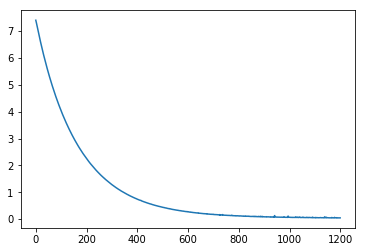

In [12]:
plt.plot(history.history['loss'])

## 5. Results and analysis

Print a dataframe of phase values generated from the autoencoder, and sort the rows according to increasing pseudotime values:

In [13]:
phase_df = model.phase_output(data)
phase_df.head()

,z_p,z_q,pseudotime
12,-0.155033,-0.987909,-2.985931
11,-0.278203,-0.960522,-2.859670
10,-0.406748,-0.913540,-2.722701
9,-0.654298,-0.756237,-2.428339
8,-0.672540,-0.740061,-2.403957


#### $z_p$ and $z_q$ are the values of each circular node in the bottleneck layer, from which the pseudotime (phase) values were extracted using argtan operations.

Next, print the lists of indices (which are the sample collection times) and phase values:

In [14]:
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()
phase_idx, phase_list

(array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 47, 46, 45, 44,
        43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27,
        26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13]),
 array([-2.9859314 , -2.85967   , -2.722701  , -2.4283388 , -2.4039571 ,
        -2.2140548 , -1.9053897 , -1.6058977 , -1.355215  , -1.322092  ,
        -1.2824936 , -1.2215086 , -1.163624  , -0.89855283, -0.5672054 ,
        -0.20132577, -0.00347561,  0.01057476,  0.02860478,  0.06237914,
         0.10739091,  0.11512419,  0.17600957,  0.39296457,  0.57594174,
         0.58393836,  0.7767658 ,  0.8961279 ,  0.936059  ,  0.98784345,
         1.0857942 ,  1.1674384 ,  1.2002525 ,  1.5117799 ,  1.5863694 ,
         1.7411203 ,  1.9288043 ,  2.124108  ,  2.132763  ,  2.4001038 ,
         2.430768  ,  2.5375497 ,  2.5801659 ,  2.900926  ,  2.9223425 ,
         3.112625  ,  3.1164014 ,  3.1387432 ], dtype=float32))

### Plotting

Produce a polar plot of phase values:

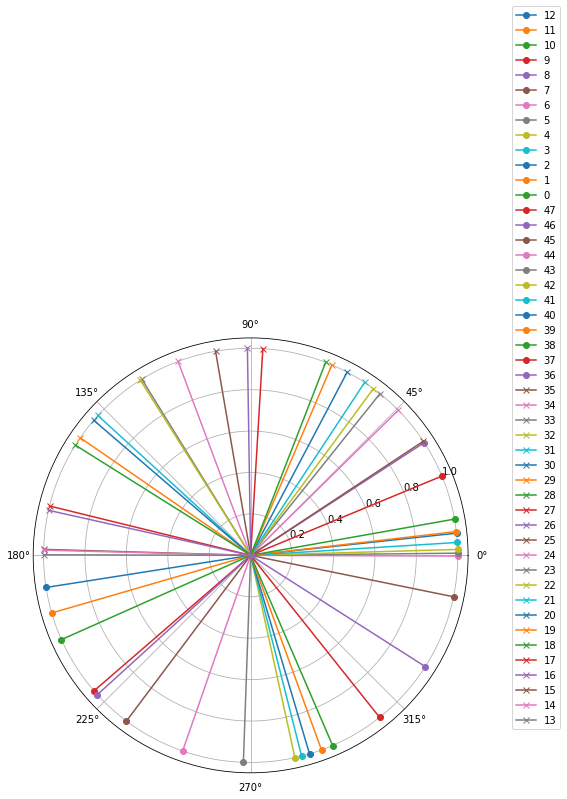

In [15]:
model.plot_polar(nc, phase_idx, phase_list)

Adjust and wrap phase values such that the phase at the first collection time (time 0) is zero:

In [16]:
idx = list(phase_idx).index(0)
phase_list -= phase_list[idx]

for i in range(len(phase_list)):
    if phase_list[i] > np.pi:
        phase_list[i] = -np.pi + (phase_list[i]-np.pi)
    elif phase_list[i] < -np.pi:
        phase_list[i] = np.pi - (-np.pi-phase_list[i])
        
phase_list

array([-1.8223073 , -1.6960459 , -1.559077  , -1.2647147 , -1.2403331 ,
       -1.0504308 , -0.7417656 , -0.44227362, -0.1915909 , -0.15846801,
       -0.11886954, -0.05788457,  0.        ,  0.2650712 ,  0.5964186 ,
        0.9622983 ,  1.1601484 ,  1.1741987 ,  1.1922288 ,  1.2260032 ,
        1.2710149 ,  1.2787483 ,  1.3396336 ,  1.5565886 ,  1.7395658 ,
        1.7475624 ,  1.9403899 ,  2.059752  ,  2.099683  ,  2.1514676 ,
        2.2494183 ,  2.3310623 ,  2.3638766 ,  2.675404  ,  2.7499933 ,
        2.9047444 ,  3.0924282 , -2.9954531 , -2.9867983 , -2.7194574 ,
       -2.6887932 , -2.5820115 , -2.5393953 , -2.2186348 , -2.1972187 ,
       -2.0069363 , -2.0031598 , -1.9808182 ], dtype=float32)

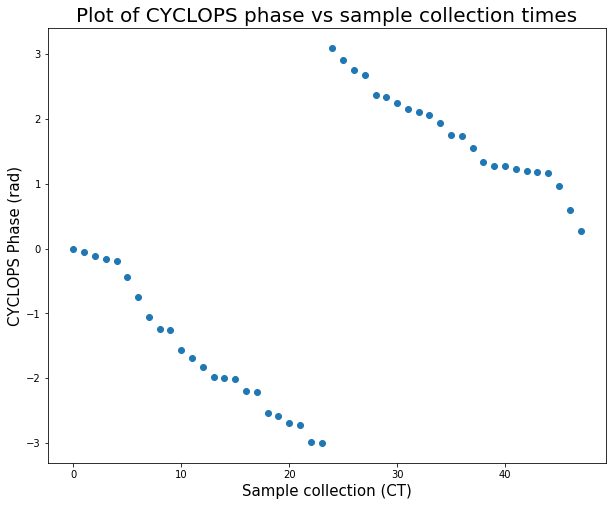

In [17]:
model.plot_phase_time(phase_idx, phase_list)

### Remapping

Create a dictionary of remapped sample indices according to increasing phase values:

In [18]:
remap_dict = model.remap(nc,phase_idx)

Re-ordering the samples from the original dataset:

In [19]:
ori = df.to_numpy().T

new = np.zeros([ng,nc])
for i in range(ng):
    for key, val in remap_dict.items():
        new[i][val-1] = ori[i][key-1]

In [20]:
new.shape

(1000, 48)

Define a sinusoidal function to fit the reordered gene expressions. The function takes 4 parameters: intercept, amplitude, frequency and phase difference:

In [21]:
def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.sin(omega * x + phi)

Create a curve fitting function that fits an optimal sinusoid to expression data for every gene:

In [22]:
from scipy import optimize
def fit_(f, xdata, ydata):
    try:
        popt, pcov = optimize.curve_fit(f, xdata, ydata)

        #Residual sum of squares (ss_res):
        residuals = ydata- f(xdata, *popt)
        ss_res = np.sum(residuals**2)

        #Total sum of squares (ss_tot):
        ss_tot = np.sum((ydata-np.mean(ydata))**2)

        r_squared = 1 - (ss_res / ss_tot)   
            
        return popt, pcov, r_squared

    except:
        pass

Store the parameter, covariance and $R^2$ values in arrays:

In [23]:
%%time

params, pcov = np.zeros([ng,4]), np.zeros([ng,4,4])
r_squared = np.zeros(ng)

for i in range(ng):
    try:
        params[i] = fit_(test_func, phase_list, new[i])[0]
        pcov[i] = fit_(test_func, phase_list, new[i])[1]
        r_squared[i] = fit_(test_func, phase_list, new[i])[2]
    except:
        continue

CPU times: user 12.1 s, sys: 116 ms, total: 12.2 s
Wall time: 14.3 s


In [24]:
params.shape, pcov.shape, r_squared.shape

((1000, 4), (1000, 4, 4), (1000,))

####  Create a dataframe of parameter and $R^2$ values and print:

_Note: if optimal parameters cannot be found for a particular gene, the parameter and $R^2$ values will be zero._

In [25]:
df_params = pd.DataFrame(params, columns=['intercept', 'amplitude', 'frequency', 'phase_shift'])
df_params['r_squared'] = r_squared

Sort the dataframe in descending order of $R^2$ values:

In [26]:
df_params = df_params.sort_values(by='r_squared', ascending = False)
df_params.head()

,intercept,amplitude,frequency,phase_shift,r_squared
916,19.703973,-13.062795,1.006756,12.544400,0.999538
994,7.977337,-18.444826,1.007445,0.514690,0.999530
970,0.121889,-14.305208,1.006898,12.720948,0.999524
984,2.290180,18.736397,1.007570,-5.618981,0.999518
915,10.222599,-16.959168,1.010129,-16.144814,0.999512


#### Plot the expression for the top 9 genes with the highest $R^2$ values:

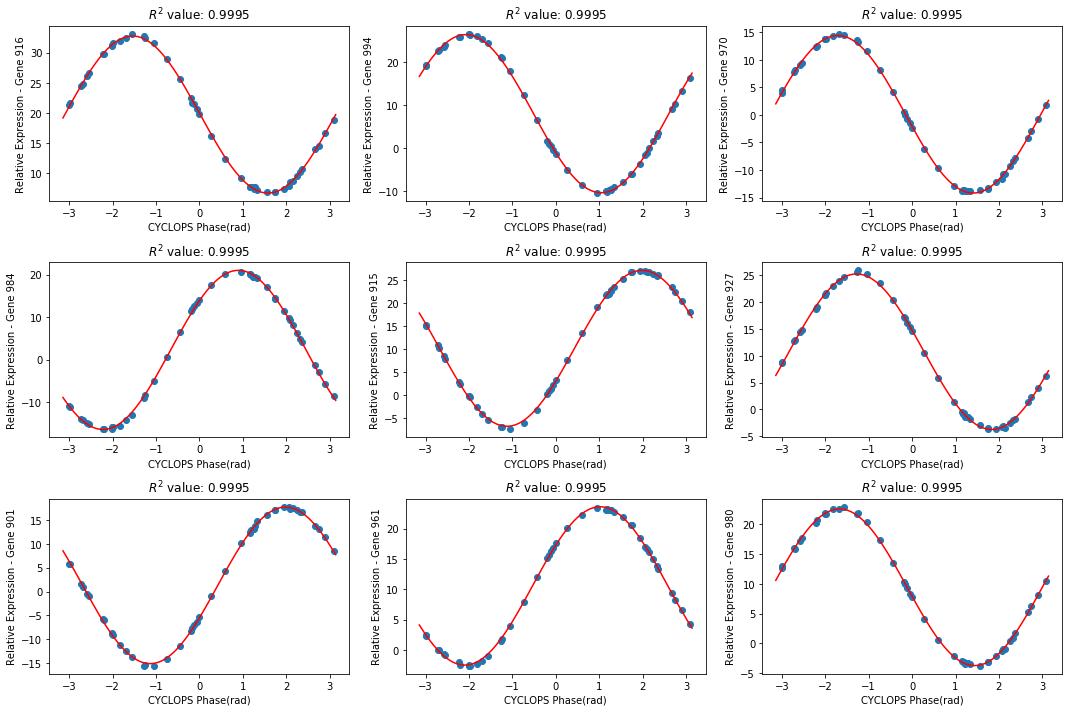

In [27]:
x = np.linspace(-np.pi,np.pi,100)

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(phase_list, new[df_params.index[i]])
    plt.plot(x, df_params.intercept.iloc[i]+df_params.amplitude.iloc[i]*np.sin(df_params.frequency.iloc[i]*x+df_params.phase_shift.iloc[i]), c='red')        
    plt.xlabel('CYCLOPS Phase(rad)')
    plt.ylabel('Relative Expression - Gene {}'.format(df_params.index[i]))
    plt.title('$R^2$ value: {:.4f}'.format(df_params.r_squared.iloc[i]))
    plt.tight_layout()